In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import gymnasium as gym
from mani_skill.utils import gym_utils
from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper
from mani_skill.utils.wrappers.record import RecordEpisode
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
from dataclasses import dataclass
import numpy as np

In [2]:
env_kwargs = dict(obs_mode="state", render_mode="rgb_array", sim_backend="gpu")
envs = gym.make('PickCube-v1', num_envs=5, reconfiguration_freq=None, **env_kwargs)

In [5]:
import sys
print(sys.executable)

/home/daniil/anaconda3/envs/rate/bin/python


In [ ]:
def smart_slice(observations, context, elapsed_steps, for_rb):
    """Возвращает срез observations с паддингом при недостатке шагов."""
    num_envs, seq_len, state_dim = observations.shape
    
    observations2RB = []
    next_observations2RB = []

    if seq_len >= context:
        for env_index in range(num_envs):
            if env_index in tracker.step_counts.keys(): # если эта среда нуждается в аккуратном срезе
                steps_since_reset = tracker.get_info(env_index)  # узнаём сколько шагов простепали после ресета
                padding_size = context - steps_since_reset       # считаем сколько шагов надо допадить
                padding = observations[env_index, -steps_since_reset, :].unsqueeze(0).repeat(padding_size, 1) # формируем паддинг
                valid_states = observations[env_index, -steps_since_reset:, :]
                next_obs = torch.cat([padding, valid_states], dim=0)  # работает если после ресета прошло мин 2 степа
                obs = torch.cat([ padding[0].unsqueeze(0), padding, valid_states[:-1,:] ], dim=0)# работает если после ресета прошло мин 2 степа
                next_observations2RB.append(next_obs)
                observations2RB.append(obs)
            elif env_index not in tracker.step_counts.keys():
                next_obs = observations[env_index, -context:, :] # всегда cont, s_d
                obs = torch.cat([ next_obs[0,:].unsqueeze(0), next_obs[:-1,:] ])   # а точно ли я должен next_obs[0,:] добавлять или надо просто другой срез сделать? 
                next_observations2RB.append(next_obs)
                observations2RB.append(obs)
        
        return torch.stack(observations2RB), torch.stack(next_observations2RB)    
    
    else:                
        padding_size = context - seq_len
        padding = observations[:, 0, :].unsqueeze(1).repeat(1, padding_size, 1)  # паддинг первым состоянием

        
        next_obs = torch.cat([padding, observations], dim=1)

        obs = torch.cat([
                observations[:, 0, :].unsqueeze(1),  # начальное состояние
                padding,
                observations[:,:-1, :]
            ], dim=1)

    return obs, next_obs

In [ ]:
def smart_slice(observations, context, elapsed_steps, for_rb=True):
    num_envs, seq_len, state_dim = observations.shape
    
    observations2RB = []
    next_observations2RB = []
    
    if for_rb: # если режем для rb
        for env_index in range(num_envs): # пробегаем по средам
            
            steps_since_reset = elapsed_steps[env_index]
            if steps_since_reset >= context:  # этого условия достаточно что бы без пад-гов сделать s и s'
                obs = observations[env_index, -context-1:-1, :]
                next_obs = observations[env_index, -context:, :]
            
            elif 0 < steps_since_reset < context:                
                padding_size = context - steps_since_reset 
                padding = observations[env_index, -steps_since_reset-1, :].unsqueeze(0).repeat(padding_size, 1) 
                valid_states = observations[env_index, -steps_since_reset-1:, :]
                intermediate_obs = torch.cat([padding, valid_states], dim=0) 
                obs = intermediate_obs[env_index, -context-1:-1, :]
                next_obs = intermediate_obs[env_index, -context:, :]
            
            elif  steps_since_reset == 0:  # это обманка, на самом деле мы не начали с нового сост-я а видим 51й кадр
                obs = observations[env_index, -context-1:-1, :]
                next_obs = observations[env_index, -context:, :]
                
            observations2RB.append(obs)
            next_observations2RB.append(next_obs)  
            
        return torch.stack(observations2RB), torch.stack(next_observations2RB)
                
    if not for_rb:
        for env_index in range(num_envs): # пробегаем по средам
            
            steps_since_reset = elapsed_steps[env_index]
            if steps_since_reset >= context-1:                  # самый позитивый сценарий, просто нарезаем и не паримся
                next_obs = observations[env_index, -context:, :]
                
            elif steps_since_reset < context-1: 
                padding_size = context - steps_since_reset - 1
                padding = observations[env_index, -steps_since_reset-1, :].unsqueeze(0).repeat(padding_size, 1)
                valid_states = observations[env_index, -steps_since_reset-1:, :]
                next_obs = torch.cat([padding, valid_states], dim=0)
             
            next_observations2RB.append(next_obs)
        
        return torch.stack(next_observations2RB)
                
            

SyntaxError: invalid syntax (3715526329.py, line 9)

In [357]:
[1].append()

TypeError: list.append() takes exactly one argument (0 given)

In [353]:
data = [0]   # interm=[0,0,0,0,1]   s=[0,0,0,0,1] s'=[0,0,0,1,2]
c = 5
ssr = 0
padding_size = c - ssr - 1

padding = data[-ssr-1]
valid_states = data[-ssr-1:]


In [356]:
valid_states

[0]

In [352]:
valid_states

[0, 1, 2, 3]

In [347]:
padding

0

In [12]:
env_kwargs = dict(obs_mode="state", render_mode="rgb_array", sim_backend="gpu")
env_kwargs["control_mode"] = "pd_joint_delta_pos"
    
envs = gym.make('PickCube-v1', num_envs=2, reconfiguration_freq=None, **env_kwargs)

In [13]:
envs = ManiSkillVectorEnv(envs, num_envs=2, ignore_terminations=True, record_metrics=True)

In [184]:
envs.reset()

(tensor([[ 1.1150e-02,  4.0779e-01, -2.2373e-02, -1.9569e+00,  1.8996e-02,
           2.3441e+00,  8.0386e-01,  4.0000e-02,  4.0000e-02,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.2717e-03,
          -5.5752e-03,  1.6226e-01, -2.2465e-03,  9.9973e-01, -2.0674e-02,
          -1.0255e-02,  3.7426e-02, -5.1588e-02,  2.8513e-02,  3.6168e-02,
           7.2479e-03,  2.0000e-02,  9.9970e-01,  0.0000e+00,  0.0000e+00,
           2.4371e-02,  3.8440e-02,  1.2823e-02, -1.4226e-01,  1.2584e-03,
          -5.8836e-02,  8.5133e-03],
         [-1.9129e-02,  3.8696e-01, -3.2823e-02, -2.0038e+00, -7.6136e-03,
           2.3730e+00,  7.6408e-01,  4.0000e-02,  4.0000e-02,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3633e-02,
          -3.2608e-02,  1.5825e-01,  8.4968e-03,  9.9986e-01, -

In [286]:
o, r, term, tru, info = envs.step(envs.action_space.sample())
print(info)

{'elapsed_steps': tensor([0, 0], device='cuda:0', dtype=torch.int32), 'success': tensor([False, False], device='cuda:0'), 'is_obj_placed': tensor([False, False], device='cuda:0'), 'is_robot_static': tensor([True, True], device='cuda:0'), 'is_grasped': tensor([False, False], device='cuda:0'), 'reconfigure': False, 'final_observation': tensor([[-1.6021e-01,  2.7413e-01, -1.8904e-01, -2.0245e+00, -1.7902e-01,
          2.5964e+00,  7.5553e-01,  2.9946e-02,  2.9946e-02,  1.8216e-01,
         -5.4423e-01,  5.4502e-01,  6.7879e-01,  1.3636e-01,  8.2061e-02,
         -4.2582e-01, -1.8103e-02, -1.8403e-02,  0.0000e+00, -3.2043e-03,
         -2.2896e-01,  2.4953e-01,  1.0838e-01,  9.8215e-01, -8.1450e-02,
          1.3042e-01,  8.4882e-02,  5.3333e-02,  6.1865e-02,  4.0793e-02,
          2.2261e-02,  2.0000e-02,  5.0411e-02,  5.4773e-06,  2.2165e-06,
         -9.9873e-01,  4.3997e-02,  2.5122e-01, -2.2953e-01,  4.4089e-02,
          3.1072e-02,  4.1865e-02],
        [ 5.1923e-02,  2.5373e-01,  

In [288]:
tru

tensor([True, True], device='cuda:0')

In [289]:
tru | term

tensor([True, True], device='cuda:0')

In [28]:
flag = False
t = 1
while not flag:
    obs = envs.step(envs.action_space.sample())
    t += 1
    flag = obs[3].item()


51

In [14]:
obs[-1]['elapsed_steps'].item()

1

In [19]:
obs[3].item()

False

In [30]:
env_kwargs = dict(obs_mode="state", render_mode="rgb_array", sim_backend="gpu")
env_kwargs["control_mode"] = "pd_joint_delta_pos"
    
envs = gym.make('PickCube-v1', num_envs=50, reconfiguration_freq=None, **env_kwargs)

rb = ReplayBuffer(envs , 50, contex, 1000000, 'cuda', 'cuda')

rb.pos = 1000

/home/daniil/anaconda3/envs/rate/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrappers.
  logger.warn(
/home/daniil/anaconda3/envs/rate/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_action_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_action_space` for environment variables or `env.get_wrapper_attr('single_action_space')` that will search the reminding wrappers.
  logger.warn(


In [ ]:
batch = rb.sample(512)

batch.obs.shape, batch.next_obs.shape, batch.actions.shape , batch.rewards.shape , batch.dones.shape


(torch.Size([512, 10, 42]),
 torch.Size([512, 10, 42]),
 torch.Size([512, 8]),
 torch.Size([512]),
 torch.Size([512]))

In [28]:
contex = 10

In [33]:
obs = torch.zeros(50,contex,42)
next_obs = torch.zeros(50,contex,42)
actions = torch.zeros(50,8)
rewards = torch.zeros(50)
dones = torch.zeros(50)

In [34]:
rb.add(obs, next_obs, actions, rewards, dones)

In [7]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        h, l = env.single_action_space.high, env.single_action_space.low
        self.register_buffer("action_scale", torch.tensor((h - l) / 2.0, dtype=torch.float32))
        self.register_buffer("action_bias", torch.tensor((h + l) / 2.0, dtype=torch.float32))
        # will be saved in the state_dict

    def forward(self, x):
        x = self.backbone(x)
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_eval_action(self, x):
        x = self.backbone(x)
        mean = self.fc_mean(x)
        action = torch.tanh(mean) * self.action_scale + self.action_bias
        return action

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        return super().to(device)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim, device, min_timescale=2.0, max_timescale=1e4):
        super().__init__()
        self.device = device
        freqs = torch.arange(0, dim, min_timescale).to(self.device)
        inv_freqs = max_timescale ** (-freqs / dim)
        self.register_buffer("inv_freqs", inv_freqs)

    def forward(self, seq_len):
        seq = torch.arange(seq_len - 1, -1, -1.0).to(self.device)
        sinusoidal_inp = rearrange(seq, "n -> n ()") * rearrange(self.inv_freqs, "d -> () d")
        pos_emb = torch.cat((sinusoidal_inp.sin(), sinusoidal_inp.cos()), dim=-1)
        return pos_emb

#######################################################################################################################################
##########################################################  Gatings  #################################################################

class GRUGate(nn.Module):

    def __init__(self, input_dim: int, bg: float = 0.0):
        
        super(GRUGate, self).__init__()
        self.Wr = nn.Linear(input_dim, input_dim, bias=False)
        self.Ur = nn.Linear(input_dim, input_dim, bias=False)
        self.Wz = nn.Linear(input_dim, input_dim, bias=False)
        self.Uz = nn.Linear(input_dim, input_dim, bias=False)
        self.Wg = nn.Linear(input_dim, input_dim, bias=False)
        self.Ug = nn.Linear(input_dim, input_dim, bias=False)
        self.bg = nn.Parameter(torch.full([input_dim], bg))  # bias
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        nn.init.xavier_uniform_(self.Wr.weight)
        nn.init.xavier_uniform_(self.Ur.weight)
        nn.init.xavier_uniform_(self.Wz.weight)
        nn.init.xavier_uniform_(self.Uz.weight)
        nn.init.xavier_uniform_(self.Wg.weight)
        nn.init.xavier_uniform_(self.Ug.weight)

    def forward(self, x: torch.Tensor, y: torch.Tensor):
        """        
        Arguments:
            x {torch.tensor} -- First input
            y {torch.tensor} -- Second input
        Returns:
            {torch.tensor} -- Output
        """
        r = self.sigmoid(self.Wr(y) + self.Ur(x))
        z = self.sigmoid(self.Wz(y) + self.Uz(x) - self.bg)
        h = self.tanh(self.Wg(y) + self.Ug(torch.mul(r, x)))

        # print(f'mean z: {z.mean()}')

        return torch.mul(1 - z, x) + torch.mul(z, h) #, z.mean()

#######################################################################################################################################
######################################################## nano gpt modification ########################################################

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
    
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.num_steps, config.num_steps))
                                        .view(1, 1, config.num_steps, config.num_steps))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y



class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

        if config.use_gates:
            self.skip_fn_1 = GRUGate(config.n_embd, 2.0)
            self.skip_fn_2 = GRUGate(config.n_embd, 2.0)
        else:
            self.skip_fn_1 = lambda x, y: x + y
            self.skip_fn_2 = lambda x, y: x + y


    def forward(self, x):

        x = self.skip_fn_1(x, self.attn(self.ln_1(x)))
        x = self.skip_fn_2(x, self.mlp(self.ln_2(x)))

        
        return x

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.config = config
        self.pos_embedding = nn.Embedding(config.max_episode_steps, config.n_embd)

        self.transformer_layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = LayerNorm(config.n_embd, bias=config.bias)
        self.drop = nn.Dropout(config.dropout)

        
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

    

    def get_num_params(self, non_embedding=True):
        
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x):

        t = x.shape[1]

        device = x.device
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
        pos_emb = self.pos_embedding(pos) # position embeddings of shape (t, n_embd)
        
        x = self.drop(x + pos_emb)
        for block in self.transformer_layers:
            x = block(x)
        x = self.ln_f(x)

        return x

# ACTOR

In [ ]:
class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.transformer = GPT(args)
        self.encoder = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        
        self.head = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        h, l = env.single_action_space.high, env.single_action_space.low
        self.register_buffer("action_scale", torch.tensor((h - l) / 2.0, dtype=torch.float32))
        self.register_buffer("action_bias", torch.tensor((h + l) / 2.0, dtype=torch.float32))
        # will be saved in the state_dict

    def forward(self, x):
        x = self.encoder(x)
        x = self.transformer(x)
        x = self.head(x)
        
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_eval_action(self, x):
        x = self.encoder(x)
        x = self.transformer(x)
        x = self.head(x)
        
        mean = self.fc_mean(x)
        action = torch.tanh(mean) * self.action_scale + self.action_bias
        return action

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        return super().to(device)

# CRITIC


In [ ]:
class QNetwork(nn.Module):
    '''
    NIK
    '''
    
    def __init__(self, env, args, transformer):
        super().__init__()
        self.transformer = GPT(args)
        self.encoder = nn.Linear(np.array(env.single_observation_space.shape).prod(), args.n_embd)
        self.fc1 = nn.Linear(np.array(args.n_embd + np.prod(env.single_action_space.shape)), args.head_dim)
        self.fc2 = nn.Linear(args.head_dim, args.head_dim)
        self.fc3 = nn.Linear(args.head_dim, 1)

    def forward(self, x, a):
        x = self.encoder(x)
        x = self.transformer(x)[:, -1, :]

        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class SoftQNetwork(nn.Module):
    '''
    MANI
    '''
    def __init__(self, env, args):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod() + np.prod(env.single_action_space.shape), 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        return self.net(x)

In [ ]:
class SoftQNetwork(nn.Module):
    '''
    Q-network for Transformer-based maniskill tasks
    '''
    def __init__(self, env, args):
        super().__init__()
        
        self.transformer = GPT(args)
        self.encoder = nn.Linear(np.array(env.single_observation_space.shape).prod(), args.n_embd)
        self.net = nn.Sequential(
            nn.Linear(args.n_embd + np.prod(env.single_action_space.shape), 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, x, a):                # x = (batch,cont,s_d)   a = (batch,a_d)
        x = self.encoder(x)                 # x = (batch,cont,n_embd)
        x = self.transformer(x)[:, -1, :]   # x = (batch,n_embd)
        x = torch.cat([x, a], 1)            # x = (batch,n_embd+a_d)
        return self.net(x)                  # x = (batch,1)

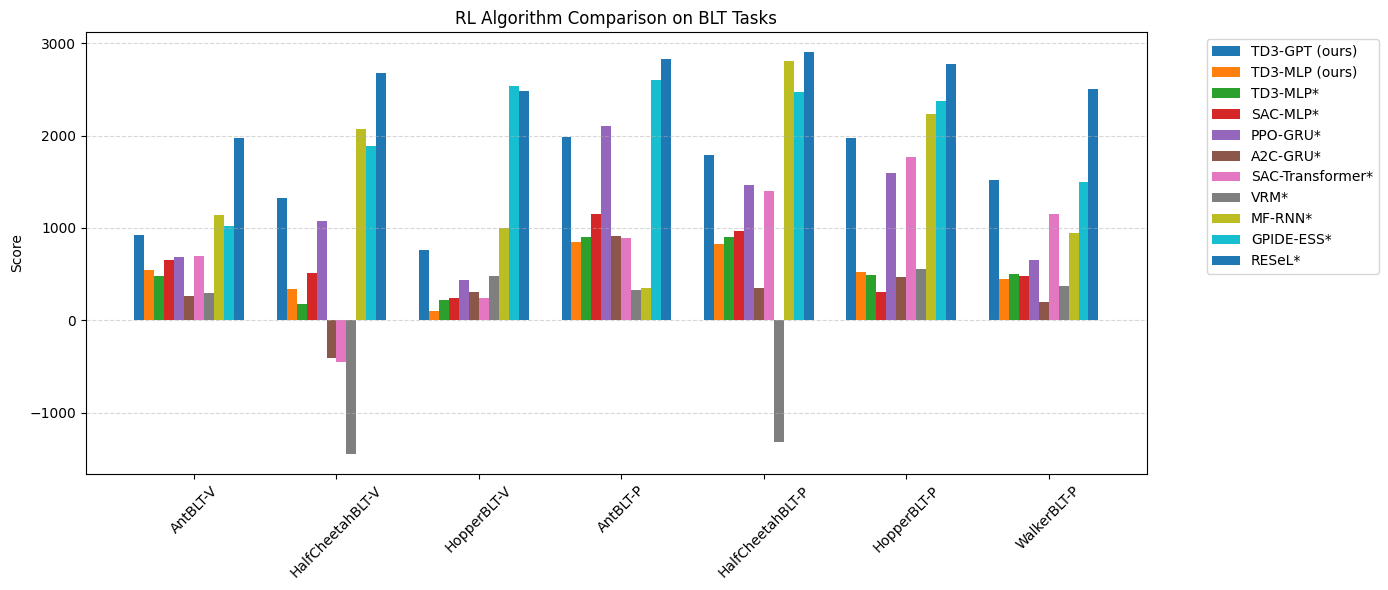

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Названия сред
envs = [
    "AntBLT-V", "HalfCheetahBLT-V", "HopperBLT-V",
    "AntBLT-P", "HalfCheetahBLT-P", "HopperBLT-P", "WalkerBLT-P"
]

# Названия алгоритмов
algos = [
    "TD3-GPT (ours)", "TD3-MLP (ours)", "TD3-MLP*", "SAC-MLP*",
    "PPO-GRU*", "A2C-GRU*", "SAC-Transformer*", "VRM*",
    "MF-RNN*", "GPIDE-ESS*", "RESeL*"
]

# Средние значения (mean) из LaTeX таблицы (без ± значения)
scores = [
    [922, 549, 476, 651, 690, 264, 692, 291, 1137, 1017, 1971],
    [1324, 343, 177, 513, 1072, -412, -449, -1443, 2073, 1886, 2678],
    [759, 98, 223, 243, 438, 301, 240, 476, 1003, 2537, 2480],
    [1984, 846, 897, 1147, 2103, 916, 894, 323, 352, 2597, 2829],
    [1788, 824, 906, 970, 1460, 353, 1400, -1317, 2802, 2466, 2900],
    [1971, 525, 490, 310, 1592, 467, 1763, 557, 2234, 2373, 2769],
    [1516, 451, 505, 483, 651, 200, 1150, 372, 940, 1502, 2505],
]

scores = np.array(scores)

# Настройки графика
num_envs = len(envs)
num_algos = len(algos)
bar_width = 0.07
x = np.arange(num_envs)

# Размер фигуры
plt.figure(figsize=(14, 6))

# Рисуем каждую группу баров
for i in range(num_algos):
    plt.bar(x + i * bar_width, scores[:, i], width=bar_width, label=algos[i])

# Настройка осей
plt.xticks(x + bar_width * (num_algos / 2), envs, rotation=45)
plt.ylabel("Score")
plt.title("RL Algorithm Comparison on BLT Tasks")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.show()